In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd

Reading original data

In [5]:
PATH_TO_DATA = 'C:\\Users\\winter\\gitlab\\learn\\ods\\data\\alice\\'
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

Let us concentrate on time features...

In [6]:
times = ['time%s' % i for i in range(1, 11)]

train_df[times] = train_df[times].apply(pd.to_datetime)

In [7]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)

time_df['min'] = train_df[times].min(axis=1) 
time_df['max'] = train_df[times].max(axis=1)
time_df['minutes'] = round(((time_df['max'] - time_df['min']) / np.timedelta64(1, 's'))/60,2)


time_df['start_month'] = time_df['min'].apply(lambda ts: 100 * ts.year + ts.month)
time_df['year'] = time_df['min'].apply(lambda ts: ts.year)
time_df['month'] = time_df['min'].apply(lambda ts: ts.month)

time_df['start_week'] = time_df['min'].apply(lambda ts: 100 * ts.year + ts.week)
time_df['start_day'] = time_df['min'].apply(lambda ts: ts.timetuple().tm_yday)
time_df['start_hour'] = time_df['min'].apply(lambda ts: ts.hour)

time_df['dow'] = time_df['min'].apply(lambda ts: ts.date().weekday())
time_df['is_weekend'] = time_df['min'].apply(lambda ts: 1 if ts.date().weekday() in (5, 6) else 0)
time_df['work_hours'] = time_df['min'].apply(lambda ts: 1 if (ts.date().weekday() in (0,1,2,3)) &
                                             ((ts.hour>=8)&(ts.hour<=17)&(ts.hour!=12)) else 0)
time_df['target'] = train_df['target']
time_df.head()

min                 max  minutes  start_month  \
session_id                                                                 
1          2014-02-20 10:02:45 2014-02-20 10:02:45     0.00       201402   
2          2014-02-22 11:19:50 2014-02-22 11:20:16     0.43       201402   
3          2013-12-16 16:40:17 2013-12-16 16:40:24     0.12       201312   
4          2014-03-28 10:52:12 2014-03-28 10:56:42     4.50       201403   
5          2014-02-28 10:53:05 2014-02-28 10:57:11     4.10       201402   

            year  month  start_week  start_day  start_hour  dow  is_weekend  \
session_id                                                                    
1           2014      2      201408         51          10    3           0   
2           2014      2      201408         53          11    5           1   
3           2013     12      201351        350          16    0           0   
4           2014      3      201413         87          10    4           0   
5           2014      2      201409         59          10    4           0   

            work_hours  target  
session_id                      
1                    1       0  
2                    0       0  
3                    1       0  
4                    0       0  
5                    0       0

Let us first observe weekday countplots... will see that counts may fail to give a good idea.

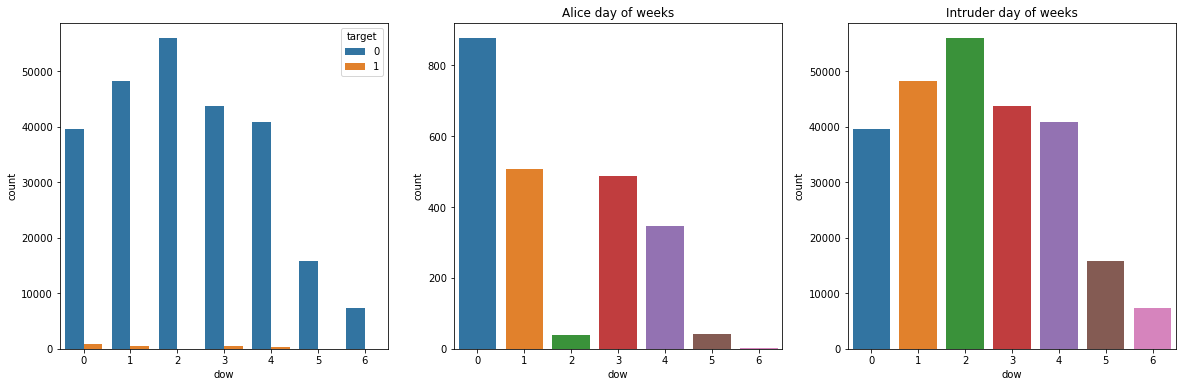

In [8]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.countplot(x="dow", hue="target", data=time_df)
plt.subplot(1, 3, 2)
plt.title('Alice day of weeks')
sns.countplot(x="dow", data=time_df[time_df['target']==1])
plt.subplot(1, 3, 3)
plt.title('Intruder day of weeks')
sns.countplot(x="dow", data=time_df[time_df['target']==0])
# plt.tight_layout()

Instead, we will look at percentages (Percentage of activity per each day among other days). 
The following way is a good way of obtaining percentage-including plots ( runs a little slower though).

Below we see that none of the weekdays exceed %20 activity for an Intruder behavior. However, Alice shows a recognizable behavior among activity per day of weeks.

In [6]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('Alice % activity at a day of week')
ax =sns.barplot(x="dow", y="dow", data=time_df[time_df['target']==1], 
                 estimator=lambda x: len(x) / len(time_df[time_df['target']==1]) * 100)
ax.set(ylabel="Percent")

plt.subplot(1, 2, 2)
plt.title('Intruder % activity at a day of week')
ax =sns.barplot(x="dow", y="dow", data=time_df[time_df['target']==0], 
                 estimator=lambda x: len(x) / len(time_df[time_df['target']==0]) * 100)
ax.set(ylabel="Percent")
plt.tight_layout()

Now let us observe start hour percentages for Alice and Intruder. We will result in a similar decision.. Starting hour is recognizable for Alice behavior.

In [37]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('Alice start hour percentage')
ax =sns.barplot(x="start_hour", y="start_hour", data=time_df[time_df['target']==1], 
                 estimator=lambda x: len(x) / len(time_df[time_df['target']==1]) * 100)
ax.set(ylabel="Percent")

plt.subplot(1, 2, 2)
plt.title('Intruder start hour percentage')
ax =sns.barplot(x="start_hour", y="start_hour", data=time_df[time_df['target']==0], 
                 estimator=lambda x: len(x) / len(time_df[time_df['target']==0]) * 100)
ax.set(ylabel="Percent")
plt.tight_layout()

Let us observe Alice's activity  among day of years.. Seems like Alice is not active at all..

In [7]:
plt.figure(figsize=(20, 8))

plt.title('Alice day of years')
sns.countplot(x="start_day", data=time_df[time_df['target']==1])
plt.tight_layout()

We may indeed have useless features for now.. See below that 'start_week' and 'year' features are highly correlated with start_month feature.

In [8]:
sns.heatmap(time_df.corr())

Now we will make use of a more useful feature about the time spent in sessions than previosly set  'seconds' feature: 'minutes'. If we look at minutes spent in sessions, we may better classify the session periods.

In [9]:
sns.lmplot('minutes', 'start_hour', data=time_df, hue='target', fit_reg=False)

In [10]:
sns.lmplot('minutes', 'dow', data=time_df, hue='target', fit_reg=False)

The below plots also show the yearly activities for Alice and Intruder

In [74]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.title('Alice % activity in 2013 and in 2014')
ax =sns.barplot(x="year", y="year", data=time_df[time_df['target']==1], 
                 estimator=lambda x: len(x) / len(time_df[time_df['target']==1]) * 100)
ax.set(ylabel="Percent")
plt.subplot(1,2,2)
plt.title('Intruder % activity in 2013 and in 2014')
ax =sns.barplot(x="year", y="year", data=time_df[time_df['target']==0], 
                 estimator=lambda x: len(x) / len(time_df[time_df['target']==0]) * 100)
ax.set(ylabel="Percent")
plt.tight_layout()

Lastly we will observe monthly behaviours;

In [11]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.title('Alice monthly % activity')
ax =sns.barplot(x="month", y="month", data=time_df[time_df['target']==1], 
                 estimator=lambda x: len(x) / len(time_df[time_df['target']==1]) * 100)
ax.set(ylabel="Percent")
plt.subplot(1,2,2)
plt.title('Intruder monthly % activity')
ax =sns.barplot(x="month", y="month", data=time_df[time_df['target']==0], 
                 estimator=lambda x: len(x) / len(time_df[time_df['target']==0]) * 100)
ax.set(ylabel="Percent")
plt.tight_layout()

In this kernel, you can figure out
- how to plot percentage-including plot pairs
- how to get rid of some useless time features

and also you can pick some useful time features for your own model.